In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
ps.set_log_level("ERROR")
%config InlineBackend.figure_format = 'svg'

## Kalibratie van een tijdreeksmodel

In algemene zin wordt onder kalibratie verstaan het vinden van de modelparameters zodat de uitkomst van het tijdreeksmodel zo goed mogelijk overeenkomt met de gemeten waarden. De gevonden parameters worden de optimale parameters genoemd. De meest gebruikte methode om de optimale parameters te vinden is de minimalisatie van de de som van de kwadraten van de verschillen tussen de gemeten stijghoogte en de gemodelleerde stijghoogte, ook wel de kleinste kwadraten methode genoemd. De som van de kwadraten is een niet-lineaire functie van de modelparameters. Om de optimale modelparameters te vinden wordt gebruikt gemaakt van een zoekmethode. 

Er bestaan een aantal verschillende zoekmethoden die gebruikt kunnen worden om de optimale modelparameters te vinden. Iedere zoekmethode is gebaseerd op een ander zoek algoritme, maar het idee is altijd hetzelfde: het model wordt een aantal keer gedraaid met verschillende waarden van de modelparameters. Gebaseerd op de verschillende modeluitkomsten (en de daaruit voorvloeiende som van de kwadraten) bepaald het zoekalgoritme een volgende mogelijke set modelparameters die een kleinere som van de kwadraten zou kunnen opleveren. Het zoekalgoritme gaat door totdat het besluit dat de beste parameters gevonden zijn. De efficientie van het zoekalgoritme wordt bepaald door het aantal keer dat het model gedraaid moet worden om de optimale modelparameters te vinden. Het is vanzelfsprekend aan te bevelen om de initiele modelparameters zo dicht mogelijk bij de optimale modelparameters te kiezen. Daartoe heeft de meeste software geprobeerd om slimme keuzes te maken voor de initiele waarden van de modelparameters, maar soms heeft de modelleur kennis van het systeem en kan het handig zijn om de initiele waarden handmatig aan te passen. 

Sommige zoekalgoritmes zoeken de optimale modelparameters door de modelparameters steeds een beetje aan te passen zodat de som van de kwadraten kleiner wordt. Dit kan tot gevolg hebben dat het zoekalgoritme in een lokaal minimum belandt. Andere zoekalgoritmes gaan ook set modelparameter draaien die juist om grotere kwadraten som geven met als doel om uiteindelijk het globale minimum te vinden. Dit kost vanzelfsprekend (veel) meer rekentijd. 

Naast de keuze van de modelstructuur, het zoekalgoritme en de initiele parameters dienen nog een aantal keuzes gemaakt te worden:

1. Hoe lang moet een stijghoogte reeks zijn om een tijdreeksmodel te kunnen maken?
2. Wanneer moet er een ruismodel gebruikt worden?

### Hoe lang moet een stijghoogte reeks zijn om een tijdreeksmodel te kunnen maken?

Zaken die besproken worden:

1. Verklarende reeksen moeten beginnen voor de gemeten stijghoogte.
2. Een stijghoogtereeks moet ten minste een aantal keer het geheugen van een systeem zijn.
3. De resultaten kunnen afhangen van het deel van de stijghoogtereeks dat gebruikt wordt voor kalibratie. 

In [2]:
ho = pd.read_csv('data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
rain = pd.read_csv('data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
evap = pd.read_csv('data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

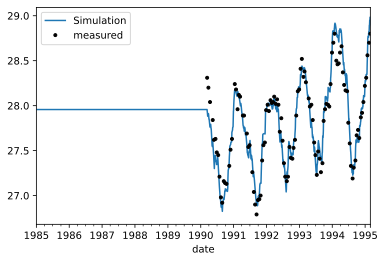

In [3]:
# start at peak
start = ho['1990'].idxmax() # peak in 1990
end = ho['1995'].idxmax() # peak in 1995
ml = ps.Model(ho)
rm = ps.RechargeModel(rain[start:], evap[start:], ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(tmin=start, tmax=end, report=False)
h = ml.simulate(tmin='1985', tmax=end)
ax = h.plot()
ho[start:end].plot(style='.', color='k', ax=ax, label='measured')
plt.legend();

p value: 7.658940795075122e-09


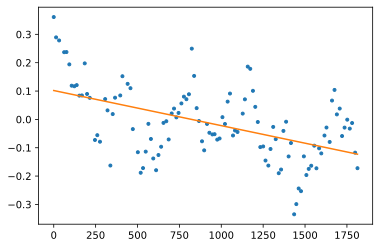

In [4]:
from scipy.stats import linregress
time = (ho[start:end].index - start).days
res = ml.residuals()
plt.plot(time, res, '.')
slope, intercept, r, p, se = linregress(time, res)
print('p value:', p)
plt.plot(time, slope * time + intercept)

## Het gebruik van een ruismodel

### Moet er een ruismodel gebruikt worden?

Een ruismodel kan gebruikt worden om te proberen er voor te zorgen dat de overgebleven verschillen tussen het model en de metingen aan een aantal statistische toetsen voldoen zodat er statistische uitspraken gedaan kunnen worden met het model (bijvoorbeeld: wat is de kans dat het effect van een onttrekking boven een bepaalde grenswaarde uitkomt). 

De verschillen tussen de gemeten stijghoogte en de gemodelleerde stijhoogte (de residuën) is vrijwel altijd gecorreleerd in de tijd. Simpel gezegd: als het model vandaag iets hoger is dan de gemeten stijghoogte, dan is de kans groot dat het model volgende week ook iets hoger is dan de gemeten stijghoogte. Dat is op zich prima te verklaren. Het kan bijvoorbeeld zo zijn dat er een regen reeks gebruikt wordt van een weerstation dat 20 km verderop ligt. Als het nu bij het regenstation wel geregend heeft maar bij de peilbuis niet, dan zal het model waarschijnlijk een te hoge stijghoogte simuleren. En aangezien het een tijdje duurt voordat de stijhoogte weer gezakt is, zal het model waarschijnlijk voor een aantal dagen of weken te hoge waarden geven. Dat is op zich geen probleem, behalve als de gebruiker het model wil gebruiken om statistische uitspraken te doen. Als er statistische uitspraken gedaan moeten worden, dan moeten de residuën aan bepaalde statistische voorwaarwaarden voldoen. Eén van de belangrijkste voorwaarden is dat de residuën niet gecorreleerd zijn. Een manier om te trachten dit te bewerkstelligen is om een ruismodel te gebruiken. Het doel van het ruismodel is om de gecorreleerde residuën te transformeren naar ruis die ongecorreleerd is. De eenvoudigste manier om te trachten dit te doen is door het gebruik van een AR1 ruismodel. In dit model is het residu $\varepsilon(t)$ op tijstip $t$ gelijk aan een factor $\rho$ keer het residu op tijdstip $t-\Delta t$ plus een random (ongecorreleerde) fout $n(t)$, of in formule vorm
$$
\varepsilon(t) = \rho \varepsilon(t - \Delta t) + n(t)
$$
Als de tijd $\Delta t$ tussen twee residuën varieert, dan kan de factor $\rho$ een functie zijn van $\Delta t$. 

In onderstaande voorbeeld worden synthetische reeksen gegeneerd en geanalyseerd om te laten zien dat bij tijdreeksmodellen zonder ruismodel de parameters wel goed geschat worden maar de betrouwbaarheidsintervallen onderschat worden.

In [5]:
ho = pd.read_csv('data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
rain = pd.read_csv('data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
evap = pd.read_csv('data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
recharge = rain - evap
delt = (ho.index[1:] - ho.index[:-1]).values / pd.Timedelta("1d")

Fit report head                  Fit Statistics
nfev     17                     EVP          90.61
nobs     644                    R2            0.91
noise    True                   RMSE          0.13
tmin     1985-11-14 00:00:00    AIC           3.17
tmax     2015-06-28 00:00:00    BIC          21.04
freq     D                      Obj           2.14
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (4 were optimized)
                optimal   stderr     initial  vary
recharge_A   797.719332   ±5.57%  215.674528  True
recharge_a   161.413117   ±5.92%   10.000000  True
constant_d    27.532182   ±0.09%   27.900078  True
noise_alpha   66.013704  ±12.86%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.93
           constant_d -0.80
recharge_a constant_d -0.75



1985-11-14   -0.147761
1985-11-28    0.018985
1985-12-14    0.049225
1985-12-28    0.053405
1986-01-13    0.079575
                ...   
2015-04-28    0.081696
2015-05-14    0.012572
2015-05-28   -0.073930
2015-06-14    0.120032
2015-06-28   -0.092199
Name: Noise, Length: 644, dtype: float64

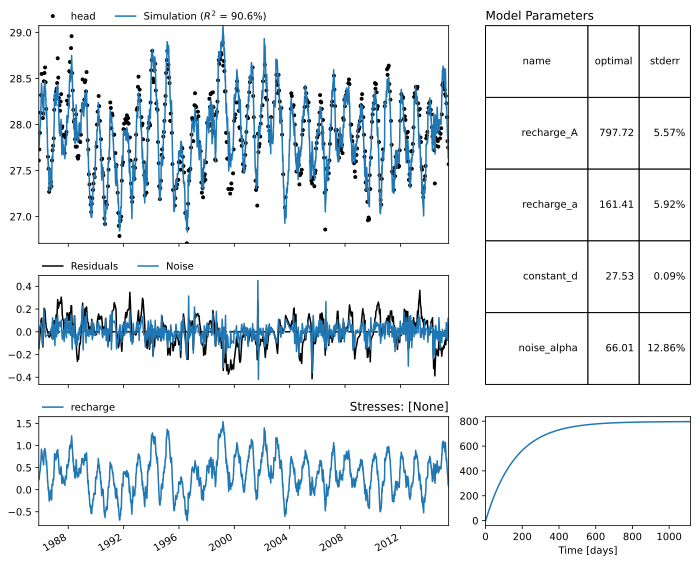

In [6]:
ml = ps.Model(ho)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve()
ml.plots.results()
ml.noise()

<AxesSubplot:>

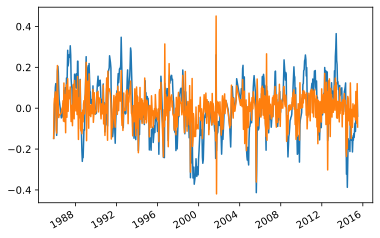

In [7]:
ml.residuals().plot()
ml.noise().plot()

Maak een model waarbij de dagelijkse grondwateraanvulling gelijk is aan de gemeten regen min de gemeten potentiele verdamping. De response functie van de grondwateraanvulling is een exponentiele functie met $A=600$ en $a=150$ d. Het basisniveau is $d=25$ m. Een synthetische stijghoogte reeks wordt gesimuleerd op dezelfde tijdstippen waarop gemeten was. Deze synthetische reeks bevat geen fouten en een tijdreeksmodel met een exponentiele response functie kan de parameters vrijwel exact terugvinden. 

In [8]:
A = 600
a = 150
d = 25
alpha = 50

<AxesSubplot:xlabel='date'>

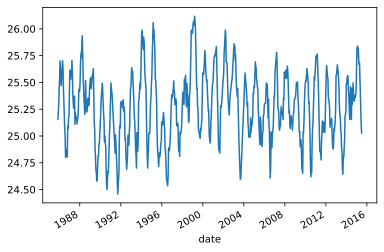

In [9]:
ml = ps.Model(ho)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.set_parameter('recharge_A', initial=A)
ml.set_parameter('recharge_a', initial=a)
ml.set_parameter('constant_d', initial=d)
hsynthetic_no_error = ml.simulate()[ho.index]
hsynthetic_no_error.plot()

Vervolgens wordt er een residu (een fout) opgeteld bij de synthetische reeks. Het residu op tijdstip $t$, $\epsilon(t)$, is gecorrleerd met het residu bij de vorige meeting op tijdstip $t-\Delta t$ volgens de formule
$$
\varepsilon(t) = \text{e}^{-\Delta t / \alpha} \varepsilon(t - \Delta t) + n(t)
$$
waarbij $\alpha$ een parameter is die aangeeft hoe veel correlatie er tussen residuen is en $n$ de noise is, een willekeurige fout die getrokken wordt uit een normale verdeling met gemiddelde nul en standaard afwijking $\sigma$. De standaardafwijking van de noise is gekozen als $\sigma=0.1$ m. Hoe groter de correlatie tussen de residuen is, hoe groter de de standaardafwijking van de residuen is. 

std residuals 0.12842200175482732
std noise 0.09478825754856138


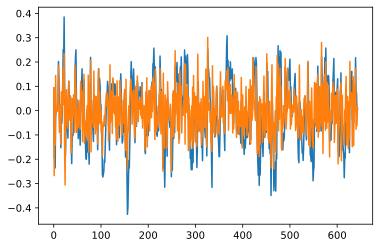

In [10]:
sigma_noise = 0.1
noise = sigma_noise * np.random.randn(len(ho))
residuals = np.zeros_like(noise)
residuals[0] = noise[0]
for i in range(1, len(ho)):
    residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
hsynthetic = hsynthetic_no_error + residuals
#
plt.plot(residuals, label='residuals')
plt.plot(noise, label='noise')
print(f'std residuals {np.std(residuals)}')
print(f'std noise {np.std(noise)}')

Vervolgens wordt er een tijdreeksmodel gemaakt voor de synthetische reeks inclusief de gecorreleerde residuen. Het tijdreeksmodel zal ongeveer de parameters terugvinden die opgegeven zijn, maar niet exact omdat er een fout opgeteld is bij de werkelijke stijghoogte. Hieronder is een voorbeeld gegeven.

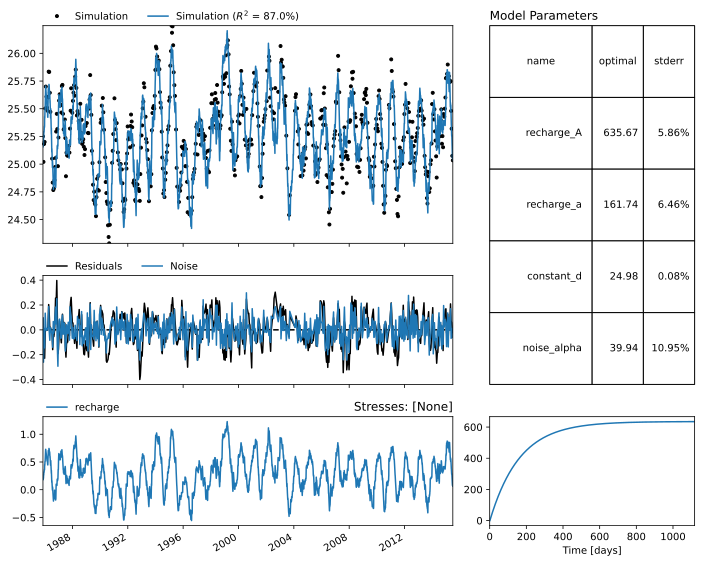

In [11]:
ml = ps.Model(hsynthetic)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False)
ml.plots.results();

Vervolgens gaan we een experiment doen. We creeeren 100 keer een synthetische reeks en gaan daar 100 keer een tijdreeksmodel van maken. Daar de synthetische reeks elke keer andere (gecorreleerde) redisuen heeft komt er elke keer wat anders uit. Maar komt er toch ongeveer de opgegeven waarden voor de parameters uit. Het experiment is twee keer gedaan. De eerste keer is er 100 keer een tijdreeksmodel gemaakt zonder een ruismodel en vervolgens is er 100 keer een tijdreeksmodel gemaakt met een ruismodel.

In [12]:
def experiment(nexp, sigma_noise=0.1, noisemodel=True):
    Aexp = np.zeros((nexp, 2))
    aexp = np.zeros((nexp, 2))
    dexp = np.zeros((nexp, 2))
    alphaexp = np.zeros((nexp, 2))
    evpexp = np.zeros(nexp)
    for iexp in range(nexp):
        if iexp % 20 == 0:
            print(iexp, end=', ')
        np.random.seed(iexp)
        noise = sigma_noise * np.random.randn(len(ho))
        residuals = np.zeros_like(noise)
        residuals[0] = noise[0]
        for i in range(1, len(ho)):
            residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
        hsynthetic = hsynthetic_no_error + residuals
        ml = ps.Model(hsynthetic)
        rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
        ml.add_stressmodel(rm)
        ml.solve(report=False, noise=noisemodel)
        Aexp[iexp] = ml.parameters.loc['recharge_A', ['optimal', 'stderr']]
        aexp[iexp] = ml.parameters.loc['recharge_a', ['optimal', 'stderr']]
        dexp[iexp] = ml.parameters.loc['constant_d', ['optimal', 'stderr']]
        if noisemodel:
            alphaexp[iexp] = ml.parameters.loc['noise_alpha', ['optimal', 'stderr']]
        evpexp[iexp] = ml.stats.evp()
    return Aexp, aexp, dexp, alphaexp, evpexp

In [13]:
result_no_noisemodel = experiment(100, noisemodel=False)

0, 20, 40, 60, 80, 

In [14]:
print('Results without a noise model')
print('Mean value of parameter A:', np.mean(result_no_noisemodel[0][:, 0]))
print('Mean value of parameter a:', np.mean(result_no_noisemodel[1][:, 0]))
print('Mean value of parameter d:', np.mean(result_no_noisemodel[2][:, 0]))

Results without a noise model
Mean value of parameter A: 604.6617309824148
Mean value of parameter a: 152.2590997834025
Mean value of parameter d: 24.997033127005306


In [15]:
result_with_noisemodel = experiment(100, noisemodel=True)

0, 20, 40, 60, 80, 

In [16]:
print('Results with a noise model')
print('Mean value of parameter A:', np.mean(result_with_noisemodel[0][:, 0]))
print('Mean value of parameter a:', np.mean(result_with_noisemodel[1][:, 0]))
print('Mean value of parameter d:', np.mean(result_with_noisemodel[2][:, 0]))
print('Mean value of parameter alpha:', np.mean(result_with_noisemodel[3][:, 0]))

Results with a noise model
Mean value of parameter A: 601.4909834713767
Mean value of parameter a: 150.8283550961852
Mean value of parameter d: 24.998188602381564
Mean value of parameter alpha: 46.90115706632419


Het blijkt dat zowel het tijdreeksmodel zonder het ruismodel als het tijdreeksmodel met het ruismodel gemiddeld een goede schatting geeft van de parameters. Dus waarom moeten we dan een ruismodel gebruiken? De reden is dat de geschatte onzekerheid van de parameters te klein is als er geen ruismodel gebruikt wordt. De statistische manier waarop de onzekerheid geschat wordt gaat er namelijk van uit dat de overgebleven ruis niet gecorreleerd is. Als de ruis echter toch gecorreleerd is, dan is de geschatte onzekerheid te klein. Dit kan gemakkelijk nagegaan worden met het hierboven uitgevoerde experiment. Tijdens het experiment zijn de parameters 100 keer geschat inclusief een schatting van de standaard fout van de parameters. Onder enkele statistische aannames (inclusied de aannames van normaliteit en ongecorreleerde ruis), varieert het 95% betrouwbaarheidsinterval van min twee keer de stanaard fout to plus twee keer de standaar fout (eigenlijk is het 1.96 i.p.v. 2, maar laten we dan hier maar afronden). Er kan dus eenvoudig nagegaan worden hoe vaak de echte waarde van de parameters ligt binnen het 95% betrouwbaarheidsinterval van de geschatte parameters. En aangezien we het experiment 100 keer gedaan hebben, zou dit ongeveer 95 keer het geval moeten zijn. Zoals te zien is hieronder, geeft het tijdreeksmodel zonder ruismodel slechts zo'n 60-65 keer een betrouwbaarheidsinterval dat de echte waarde bevat. Het tijdreeksmodel met een ruismodel doet het veel beter: meer dan 95 keer liggen de echte parameters binnen het 95% betrouwbaarheidsinterval, behalve voor de parameter $\alpha$ van het ruismodel. 

In [17]:
Aexp, aexp, dexp, alphaexp, evp = result_no_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:', np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:', np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:', np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 58
number of times true a within estimated confidence interval: 69
number of times true d within estimated confidence interval: 64


In [18]:
Aexp, aexp, dexp, alphaexp, evp = result_with_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:', np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:', np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:', np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))
print('number of times true alpha within estimated confidence interval:', np.count_nonzero(np.abs(alphaexp[:, 0] - alpha) < 1.96 * alphaexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 98
number of times true a within estimated confidence interval: 98
number of times true d within estimated confidence interval: 96
number of times true alpha within estimated confidence interval: 82


In bovenstaand exeriment is uitgelegd wat het voordeel van het gebruik van een ruismodel is. Als er geen ruismodel gebruikt wordt, dan worden de parameters goed geschat, maar de betrouwbaarheidsintervallen van de parameters is te klein. Als het ruismodel wel meegenomen wordt, dan wordt het betrouwbaarheidsinterval veel beter geschat. 

### Wat als een eenvoudig ruismodel niet werkt?

1. Voorbeeld waarbij het ruismodel werkt als de tijdsperiode tussen metingen vergroot wordt
2. Voorbeeld ARMA1,1 ruismodel?